In [ ]:
import pandas as pd
from pathlib import Path

def load_experiment_csv(path: Path):
    # read meta line
    with open(path, "r") as f:
        meta_header = f.readline().strip().split(",")
        meta_values = f.readline().strip().split(",")
    meta = dict(zip(meta_header, meta_values))
    logs = pd.read_csv(path, skiprows=2)
    return meta, logs

# Point to your multirun directory
base = Path("multirun/2025-09-21_13-55-16/default")

results = []
for csv in base.rglob("metrics.csv"):
    meta, logs = load_experiment_csv(csv)
    logs = logs.assign(**meta)  # add metadata to each row
    results.append(logs)

df = pd.concat(results, ignore_index=True)

# Convert types
df["width"] = df["width"].astype(float)
df["seed"] = df["seed"].astype(int)
df["noise"] = df["noise"].astype(float)
df["params"] = df["params"].astype(int)

# Take only the final epoch from each run
last_epoch = df.groupby(["arch", "width", "seed"]).tail(1)

# Aggregate over seeds
agg = (
    last_epoch.groupby(["arch", "width"])
    .agg(
        test_acc_mean=("test_acc", "mean"),
        test_acc_std=("test_acc", "std"),
        test_loss_mean=("test_loss", "mean"),
        test_loss_std=("test_loss", "std"),
        runs=("seed", "count"),
    )
    .reset_index()
)

# Print nicely
for _, row in agg.iterrows():
    print(
        f"{row.arch}, width={row.width:.3f}: "
        f"Acc={row.test_acc_mean:.3f} ± {row.test_acc_std:.3f} "
        f"(n={row.runs}), "
        f"Loss={row.test_loss_mean:.3f} ± {row.test_loss_std:.3f}"
    )


resnet18, width=0.075: Acc=0.449 ± 0.007 (n=2), Loss=1.555 ± 0.003
resnet18, width=0.200: Acc=0.579 ± 0.003 (n=2), Loss=1.236 ± 0.017
resnet18, width=1.000: Acc=0.718 ± 0.001 (n=2), Loss=0.885 ± 0.005


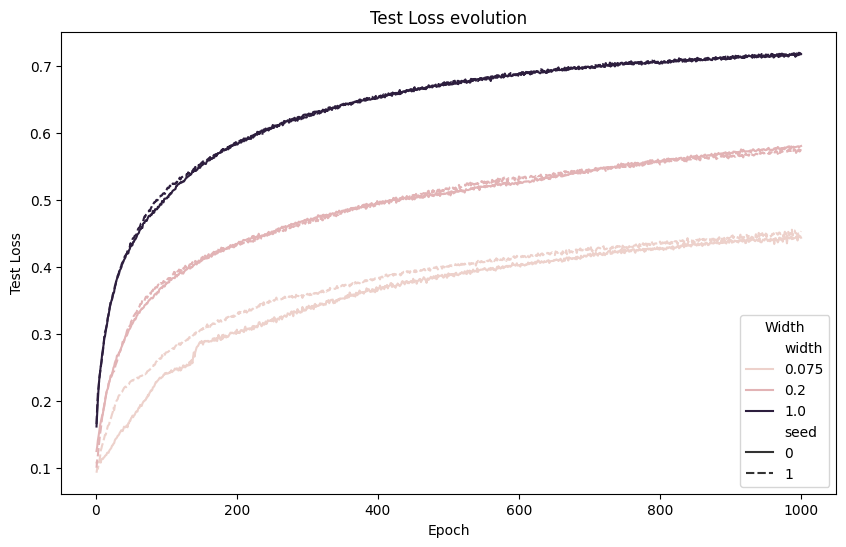

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Suppose `df` is already loaded from all metrics.csv
# df has columns: epoch, train_loss, test_loss, width, seed, arch, ...

# Example: plot test loss for each width, each seed
plt.figure(figsize=(10,6))
sns.lineplot(
    data=df,
    x="epoch", y="test_acc",
    hue="width", style="seed",
    estimator=None  # plot each seed separately
)
plt.title("Test Loss evolution")
plt.ylabel("Test Loss")
plt.xlabel("Epoch")
plt.legend(title="Width")
plt.show()


C:\Users\luord\AppData\Local\Temp\ipykernel_31316\4051854131.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(


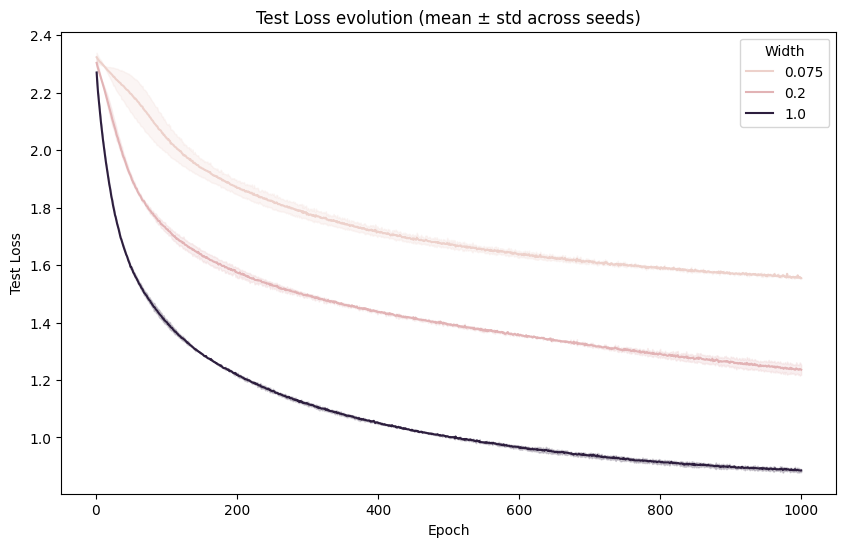

In [20]:
plt.figure(figsize=(10,6))
sns.lineplot(
    data=df,
    x="epoch", y="test_loss",
    hue="width",
    ci="sd"  # shaded std deviation across seeds
)
plt.title("Test Loss evolution (mean ± std across seeds)")
plt.ylabel("Test Loss")
plt.xlabel("Epoch")
plt.legend(title="Width")
plt.show()


C:\Users\luord\AppData\Local\Temp\ipykernel_31316\94895203.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(


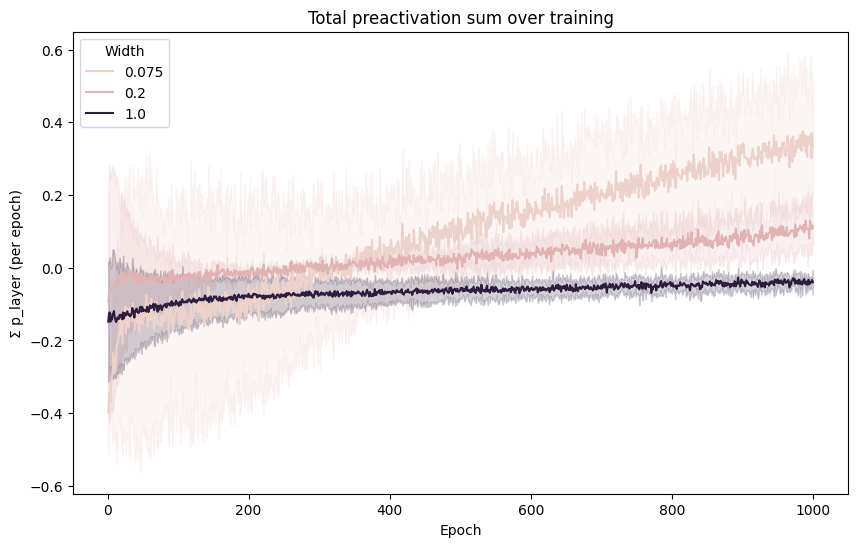

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: compute p_sum ---
p_layer_cols = [c for c in df.columns if c.startswith("p_layer")]
df["p_sum"] = df[p_layer_cols].sum(axis=1)

# --- Step 2: group by width + seed + epoch ---
# (You can keep as-is for per-seed plots, or average across seeds)
# For std shading, let Seaborn handle it.

# --- Step 3: plot ---
plt.figure(figsize=(10,6))
sns.lineplot(
    data=df,
    x="epoch", y="p_sum",
    hue="width",
    ci="sd"  # std deviation across seeds
)
plt.title("Total preactivation sum over training")
plt.ylabel("Σ p_layer (per epoch)")
plt.xlabel("Epoch")
plt.legend(title="Width")
plt.show()


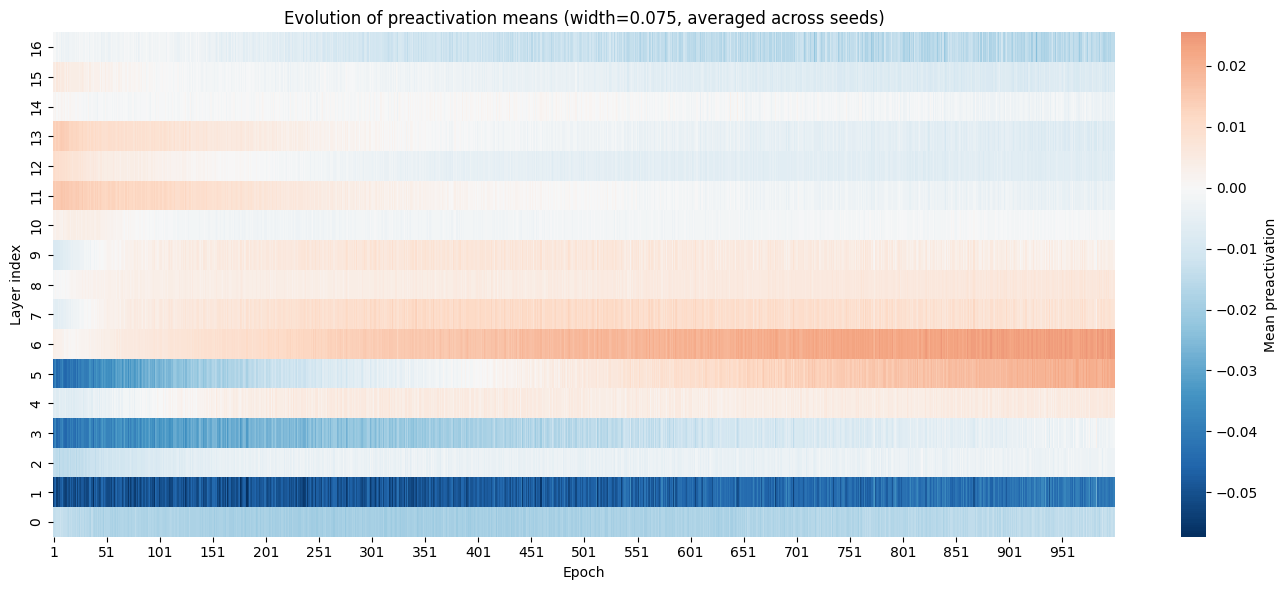

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

def load_experiment_csv(path: Path):
    with open(path, "r") as f:
        meta_header = f.readline().strip().split(",")
        meta_values = f.readline().strip().split(",")
    meta = dict(zip(meta_header, meta_values))
    logs = pd.read_csv(path, skiprows=2)
    return meta, logs

# --- Load experiments ---
base = Path("multirun/2025-09-19_18-34-32/default")

results = []
for csv in base.rglob("metrics.csv"):
    meta, logs = load_experiment_csv(csv)
    logs = logs.assign(**meta)  # add metadata to each row
    results.append(logs)

df = pd.concat(results, ignore_index=True)

# Convert metadata types
df["width"] = df["width"].astype(float)
df["seed"] = df["seed"].astype(int)
df["noise"] = df["noise"].astype(float)
df["params"] = df["params"].astype(int)

# --- Filter for width=0.075 (optional, drop if you want all widths) ---
df = df[df["width"] == 1]

# --- Melt into long form ---
p_layer_cols = [c for c in df.columns if c.startswith("p_layer")]
df_long = df.melt(
    id_vars=["epoch", "seed"],   # keep seed so we can average
    value_vars=p_layer_cols,
    var_name="layer",
    value_name="p_value"
)
df_long["layer"] = df_long["layer"].str.replace("p_layer", "").astype(int)

# --- Average across seeds ---
df_long_mean = (
    df_long.groupby(["layer", "epoch"], as_index=False)
    .agg(p_value=("p_value", "mean"))
)

# --- Pivot for heatmap ---
pivot = df_long_mean.pivot(index="layer", columns="epoch", values="p_value")

# --- Plot ---
plt.figure(figsize=(14, 6))
sns.heatmap(
    pivot,
    cmap="RdBu_r", center=0,
    cbar_kws={"label": "Mean preactivation"},
    xticklabels=50
)
plt.title("Evolution of preactivation means (width=0.075, averaged across seeds)")
plt.xlabel("Epoch")
plt.ylabel("Layer index")
plt.gca().invert_yaxis()  # deeper layers at the bottom
plt.tight_layout()
plt.show()

